In [18]:
import numpy as np
import scipy.constants as const
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# --- 1D Schrödinger-Poisson Simulation ---

def simulate_1d_qdot():
    # Physical constants and parameters
    L = 100e-9  # 100 nm domain
    N = 100    # grid points
    dx = L / N
    x = np.linspace(0, L, N)
    m_eff = 0.067 * const.m_e  # effective mass for GaAs
    eps_r = 12.9
    eps0 = const.epsilon_0
    eps = eps_r * eps0
    hbar = const.hbar
    e = const.e

    # External potential: two barriers + central plunger
    # def V_ext(x):
    #     b1 = np.exp(-((x - 20e-9) / 5e-9)**2)
    #     b2 = np.exp(-((x - 80e-9) / 5e-9)**2)
    #     plunger = -0.05 * np.exp(-((x - 50e-9) / 10e-9)**2)
    #     return 0.3 * (b1 + b2) + plunger
    def V_ext(x, V_sd=0.05):
        b1 = np.exp(-((x - 20e-9) / 5e-9)**2)
        b2 = np.exp(-((x - 80e-9) / 5e-9)**2)
        plunger = -0.05 * np.exp(-((x - 50e-9) / 10e-9)**2)
        linear_bias = V_sd * (x / x[-1])  # 0 to V_sd across device
        return 0.3 * (b1 + b2) + plunger + linear_bias

    V0 = V_ext(x)

    # Finite difference Laplacian (1D)
    main_diag = -2 * np.ones(N)
    off_diag = np.ones(N - 1)
    laplacian = (np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)) / dx**2
    H_base = - (hbar**2 / (2 * m_eff)) * laplacian

    # Poisson solver matrix (tridiagonal)
    A_poisson = (np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1)) / dx**2
    A_poisson[0,0] = A_poisson[-1,-1] = 1  # Dirichlet BCs

    # Initialize potential
    phi = np.zeros(N)
    n_iter = 30
    E_fermi = 0.05  # 50 meV

    for it in range(n_iter):
        V = V0 - e * phi
        H = H_base + np.diag(V)
        eigvals, eigvecs = spla.eigsh(sp.csr_matrix(H), k=5, which='SA', maxiter=5000, tol=1e-8)

        n_e = np.zeros(N)
        for i, E in enumerate(eigvals):
            if E < E_fermi:
                psi = eigvecs[:, i]
                psi2 = np.abs(psi)**2
                psi2 /= np.sum(psi2) * dx
                n_e += psi2
        rho = -e * n_e
        b = -rho / eps
        b[0] = b[-1] = 0  # Dirichlet BCs
        phi = np.linalg.solve(A_poisson, b)

    return x * 1e9, V0 / e, V / e, n_e

# --- 2D Schrödinger-Poisson Simulation (simplified) ---

def simulate_2d_qdot():
    # Physical constants
    Lx, Ly = 200e-9, 100e-9  # domain size (x, y)
    Nx, Ny = 200, 100        # grid resolution
    dx, dy = Lx / Nx, Ly / Ny
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    m_eff = 0.067 * const.m_e
    eps = 12.9 * const.epsilon_0
    hbar = const.hbar
    e = const.e

    # Define external potential
    # def V_ext_2d(X, Y):
    #     barrier_left = np.exp(-((X - 50e-9)/10e-9)**2)
    #     barrier_right = np.exp(-((X - 150e-9)/10e-9)**2)
    #     plunger = -0.05 * np.exp(-(((X - 100e-9)/20e-9)**2 + ((Y - 50e-9)/25e-9)**2))
    #     return 0.3 * (barrier_left + barrier_right) + plunger

    def V_ext_2d(X, Y, V_sd=0.05):
        barrier_left = np.exp(-((X - 50e-9)/10e-9)**2)
        barrier_right = np.exp(-((X - 150e-9)/10e-9)**2)
        plunger = -0.05 * np.exp(-(((X - 100e-9)/20e-9)**2 + ((Y - 50e-9)/25e-9)**2))
        linear_bias = V_sd * (X / np.max(X))
        return 0.3 * (barrier_left + barrier_right) + plunger + linear_bias


    V0 = V_ext_2d(X, Y)

    # Flatten grid
    N = Nx * Ny
    def laplacian_2d(Nx, Ny, dx, dy):
        Ix = sp.eye(Nx)
        Iy = sp.eye(Ny)
        Dx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx)) / dx**2
        Dy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Ny, Ny)) / dy**2
        return sp.kron(Iy, Dx) + sp.kron(Dy, Ix)

    L2D = - (hbar**2 / (2 * m_eff)) * laplacian_2d(Nx, Ny, dx, dy)
    phi = np.zeros((Nx, Ny))
    V = V0.copy()
    n_iter = 20
    E_fermi = 0.05

    for it in range(n_iter):
        V_total = V0 - e * phi
        H = L2D + sp.diags(V_total.flatten())
        eigvals, eigvecs = spla.eigsh(sp.csr_matrix(H), k=5, which='SA', maxiter=5000, tol=1e-8)
        n_e = np.zeros_like(phi)
        for i, E in enumerate(eigvals):
            if E < E_fermi:
                psi = np.abs(eigvecs[:, i].reshape((Nx, Ny)))**2
                psi /= np.sum(psi) * dx * dy
                n_e += psi
        rho = -e * n_e
        b = -rho.flatten() / eps
        phi_vec = spla.spsolve(laplacian_2d(Nx, Ny, dx, dy), b)
        phi = phi_vec.reshape((Nx, Ny))

    return X * 1e9, Y * 1e9, V0 / e, V_total / e, n_e





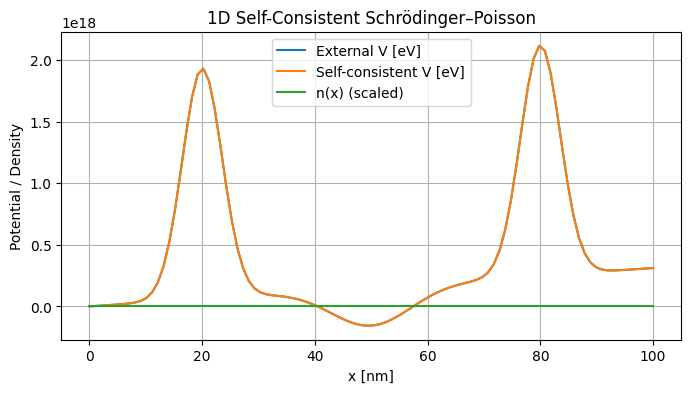

In [17]:
x, V0, V_total, n_e = simulate_1d_qdot()

plt.figure(figsize=(8, 4))
plt.plot(x, V0, label='External V [eV]')
plt.plot(x, V_total, label='Self-consistent V [eV]')
plt.plot(x, n_e / np.max(n_e) * 0.1, label='n(x) (scaled)')
plt.xlabel("x [nm]")
plt.ylabel("Potential / Density")
plt.legend()
plt.title("1D Self-Consistent Schrödinger–Poisson")
plt.grid()
plt.show()


In [25]:
import numpy as np
import numpy as np
import scipy.constants as const
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def simulate_2d_rectangular_gates(
    V1=-0.3, Vx=-0.4, V2=-0.3, V_sd=0.0, Nx=200, Ny=100, n_iter=20
):
    # Domain and constants
    Lx, Ly = 250e-9, 200e-9  # elongated layout
    dx, dy = Lx / Nx, Ly / Ny
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    m_eff = 0.067 * const.m_e
    eps = 12.9 * const.epsilon_0
    hbar = const.hbar
    e = const.e

    # Gate dimensions (in meters)
    gate_width = 40e-9
    gate_height = 50e-9
    gate_y_center = 100e-9

    # Define gate positions
    left_x = 90e-9
    center_x = 130e-9
    right_x = 170e-9

    def rect_gate(xc, yc, w, h):
        return ((X > xc - w/2) & (X < xc + w/2) &
                (Y > yc - h/2) & (Y < yc + h/2))

    left_gate = rect_gate(left_x, gate_y_center, gate_width, gate_height)
    center_gate = rect_gate(center_x, gate_y_center, gate_width, gate_height)
    right_gate = rect_gate(right_x, gate_y_center, gate_width, gate_height)

    V0 = np.zeros((Nx, Ny))
    V0[left_gate] = V1
    V0[center_gate] = Vx
    V0[right_gate] = V2

    if V_sd != 0:
        V0 += V_sd * (X / np.max(X))

    gates = {
        'V1': left_gate,
        'Vx': center_gate,
        'V2': right_gate
    }

    # Laplacian
    N = Nx * Ny
    def laplacian_2d(Nx, Ny, dx, dy):
        Ix = sp.eye(Nx)
        Iy = sp.eye(Ny)
        Dx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx)) / dx**2
        Dy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(Ny, Ny)) / dy**2
        return sp.kron(Iy, Dx) + sp.kron(Dy, Ix)

    L2D = - (hbar**2 / (2 * m_eff)) * laplacian_2d(Nx, Ny, dx, dy)

    phi = np.zeros((Nx, Ny))
    E_fermi = 0.05
    V_total = V0.copy()

    for _ in range(n_iter):
        H = L2D + sp.diags((V_total).flatten())
        eigvals, eigvecs = spla.eigsh(H, k=5, which='SA', maxiter=3000, tol=1e-6)
        n_e = np.zeros((Nx, Ny))
        for i, E in enumerate(eigvals):
            if E < E_fermi:
                psi = np.abs(eigvecs[:, i].reshape((Nx, Ny)))**2
                psi /= np.sum(psi) * dx * dy
                n_e += psi
        rho = -e * n_e
        b = -rho.flatten() / eps
        phi_vec = spla.spsolve(laplacian_2d(Nx, Ny, dx, dy), b)
        phi = phi_vec.reshape((Nx, Ny))
        V_total = V0 - e * phi

    return X * 1e9, Y * 1e9, V0 / e, V_total / e, n_e, gates



def plot_2d_with_gates(X, Y, Z, title, gates, cmap='viridis'):
    plt.figure(figsize=(6, 4))
    mesh = plt.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
    for name, mask in gates.items():
        plt.contour(X, Y, mask.astype(float), levels=[0.5], colors='white', linewidths=1.2, linestyles='--')
    plt.colorbar(mesh)
    plt.title(title)
    plt.xlabel("x [nm]")
    plt.ylabel("y [nm]")
    plt.tight_layout()
    plt.show()




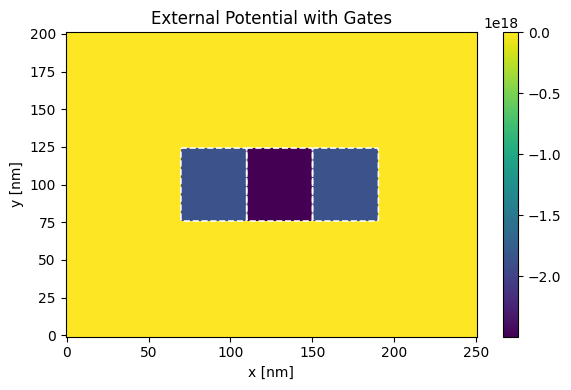

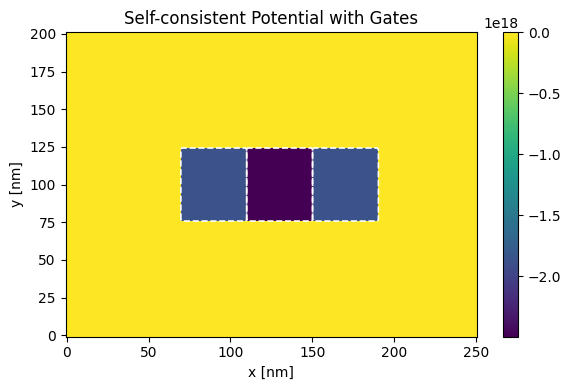

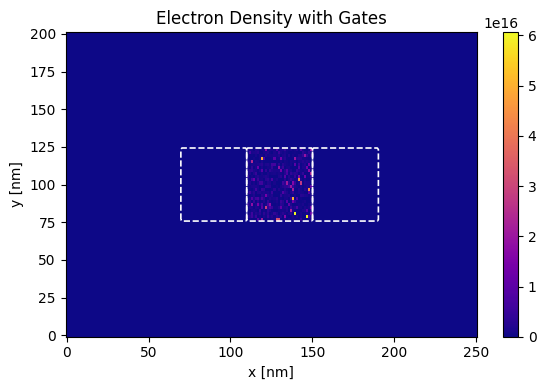

In [26]:
X, Y, Vext, Vsc, n_e, gates = simulate_2d_rectangular_gates()

plot_2d_with_gates(X, Y, Vext, "External Potential with Gates", gates)
plot_2d_with_gates(X, Y, Vsc, "Self-consistent Potential with Gates", gates)
plot_2d_with_gates(X, Y, n_e, "Electron Density with Gates", gates, cmap='plasma')


In [ ]:
import numpy as np
import scipy.constants as const

def generate_charge_stability_diagram(
    Vx_vals=np.linspace(-0.5, 0.0, 20),
    V1_vals=np.linspace(-0.5, 0.0, 20),
    V2=-0.3,
    V_sd=0.0,
    Nx=100,
    Ny=50,
    n_iter=15
):
    Q_map = np.zeros((len(V1_vals), len(Vx_vals)))
    dx = 250e-9 / Nx
    dy = 200e-9 / Ny
    area = dx * dy
    for i, V1 in enumerate(V1_vals):
        for j, Vx in enumerate(Vx_vals):
            _, _, _, _, n_e, _ = simulate_2d_rectangular_gates(
                V1=V1, Vx=Vx, V2=V2, V_sd=V_sd, Nx=Nx, Ny=Ny, n_iter=n_iter
            )
            total_charge = -const.e * np.sum(n_e) * area  # in Coulombs
            Q_map[i, j] = total_charge / const.e  # in units of |e|
    return Vx_vals, V1_vals, Q_map


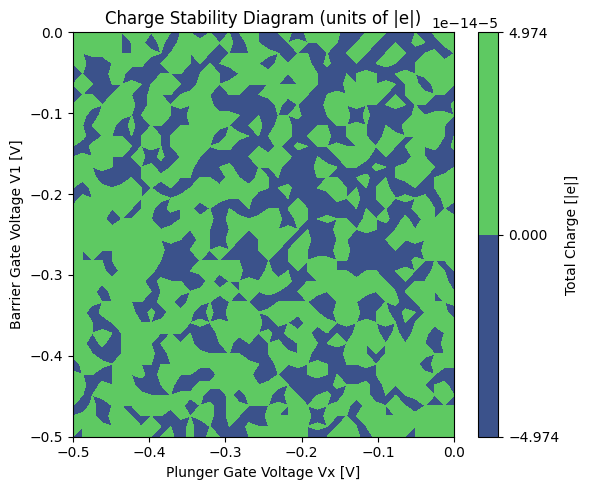

In [30]:
import matplotlib.pyplot as plt

Vx_vals, V1_vals, Q_map = generate_charge_stability_diagram()

plt.figure(figsize=(6, 5))
plt.contourf(Vx_vals, V1_vals, Q_map, levels=20, cmap='viridis')
plt.xlabel("Plunger Gate Voltage Vx [V]")
plt.ylabel("Barrier Gate Voltage V1 [V]")
plt.title("Charge Stability Diagram (units of |e|)")
plt.colorbar(label="Total Charge [|e|]")
plt.tight_layout()
plt.show()


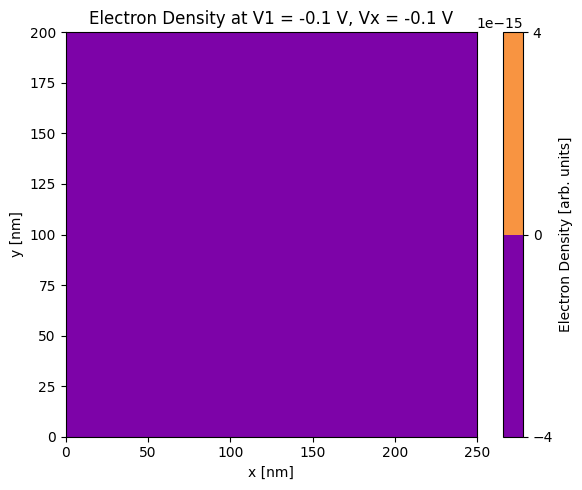

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

def simulate_2d_rectangular_gates(
    V1=-0.2, Vx=-0.2, V2=-0.2, V_sd=0.0,
    Nx=100, Ny=50, n_iter=10
):
    # Domain size in meters
    Lx = 250e-9
    Ly = 200e-9
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y)

    # External potential
    Vext = np.zeros_like(X)
    gates = {}

    def rect_mask(x0, x1, y0, y1):
        return (X >= x0) & (X <= x1) & (Y >= y0) & (Y <= y1)

    gates['V1'] = rect_mask(80e-9, 120e-9, 80e-9, 120e-9)
    gates['Vx'] = rect_mask(120e-9, 160e-9, 80e-9, 120e-9)
    gates['V2'] = rect_mask(160e-9, 200e-9, 80e-9, 120e-9)

    Vext[gates['V1']] = V1
    Vext[gates['Vx']] = Vx
    Vext[gates['V2']] = V2

    Vsc = Vext.copy()
    n_e = np.zeros_like(X)

    for _ in range(n_iter):
        # Simplified electron density model
        n_e = np.maximum(0, -(Vsc - Vsc.min()))
        rho = -const.e * n_e
        rho -= rho.mean()  # neutrality

        # Simple relaxation method for Poisson's equation
        for _ in range(100):
            Vsc[1:-1, 1:-1] = (
                Vsc[2:, 1:-1] + Vsc[:-2, 1:-1] +
                Vsc[1:-1, 2:] + Vsc[1:-1, :-2] -
                dx * dy * rho[1:-1, 1:-1] / const.epsilon_0
            ) / 4

    return X * 1e9, Y * 1e9, Vext, Vsc, n_e, gates  # Return in nm


# --- DEBUGGING CONFIGURATION ---

V1_debug = -0.1  # Barrier 1 voltage [V]
Vx_debug = -0.1  # Plunger voltage [V]
V2_debug = -0.1  # Barrier 2 voltage [V]
V_sd_debug = 0.0 # Source-drain [V]

X, Y, Vext, Vsc, n_e, gates = simulate_2d_rectangular_gates(
    V1=V1_debug, Vx=Vx_debug, V2=V2_debug,
    V_sd=V_sd_debug, Nx=100, Ny=50, n_iter=50
)

# --- PLOT ELECTRON DENSITY ---
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, n_e, levels=50, cmap='plasma')
plt.colorbar(label="Electron Density [arb. units]")
plt.title(f"Electron Density at V1 = {V1_debug} V, Vx = {Vx_debug} V")
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const
from scipy.sparse import diags, kron, identity
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import spsolve, cg
from scipy.sparse.linalg import LinearOperator, cg, spilu
from scipy.sparse.linalg import gmres

# Physical constants
e = const.e           # elementary charge
ε_0 = const.epsilon_0  # vacuum permittivity
ħ = const.hbar        # reduced Planck constant
m_eff = 0.067 * const.m_e  # effective mass in GaAs
ε_r = 12.9            # relative permittivity of GaAs
ε = ε_0 * ε_r

# Simulation domain (nm -> m)
Lx_nm, Ly_nm = 300, 200
dx_nm = dy_nm = 2.0
Lx = Lx_nm * 1e-9
Ly = Ly_nm * 1e-9
dx = dx_nm * 1e-9
dy = dy_nm * 1e-9

nx = int(Lx / dx)
ny = int(Ly / dy)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Gate definitions
def define_gates(X, Y, V1, Vx, V2):
    gates = {
        'V1': ((100e-9 < X) & (X < 130e-9) & (80e-9 < Y) & (Y < 120e-9)),
        'Vx': ((130e-9 < X) & (X < 170e-9) & (80e-9 < Y) & (Y < 120e-9)),
        'V2': ((170e-9 < X) & (X < 200e-9) & (80e-9 < Y) & (Y < 120e-9)),
    }
    Vext = np.zeros_like(X)
    for name, mask in gates.items():
        Vgate = {'V1': V1, 'Vx': Vx, 'V2': V2}[name]
        Vext[mask] += Vgate
    return Vext, gates

# Thomas–Fermi model for electron density
def compute_electron_density(Vsc, E_F):
    return (2 * m_eff / (np.pi * ħ**2)) * np.maximum(0, E_F - Vsc)

# Solve Poisson's equation
def poisson_solver(rho, epsilon, dx, dy):
    nx, ny = rho.shape

    # 1D Laplacians
    Dx = diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dy = diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    L = kron(identity(ny), Dx) + kron(Dy, identity(nx))

    b = -rho.flatten() / epsilon

    # ILU preconditioner
    ilu = spilu(L.tocsc())
    Mx = LinearOperator(L.shape, ilu.solve)

    V_flat, info = gmres(L, b, restart=50, maxiter=1000, rtol=1e-6, M=Mx)

    if info != 0:
        print(f"[Warning] CG with ILU did not fully converge. info = {info}")
    return V_flat.reshape((nx, ny))

# Self-consistent loop
def self_consistent_loop(Vext, E_F, max_iter=30, tol=1e-3):
    Vsc = Vext.copy()
    for i in range(max_iter):
        n_e = compute_electron_density(Vsc, E_F)
        rho = -e * n_e
        Vnew = poisson_solver(rho, ε, dx, dy)
        dV = np.max(np.abs(Vnew - Vsc))
        Vsc = 0.5 * Vsc + 0.5 * Vnew  # mixing
        if dV < tol:
            print(f'Converged at iteration {i}')
            break
    return Vsc, n_e

# Main simulation function
def simulate_2d_qdot(V1=-0.3, Vx=-0.3, V2=-0.3, E_F=10e-3 * e):
    Vext, gates = define_gates(X, Y, V1, Vx, V2)
    Vsc, n_e = self_consistent_loop(Vext, E_F)
    total_charge = np.sum(n_e) * dx * dy / e  # in units of |e|
    return Vext, Vsc, n_e, gates, total_charge

# Example charge stability diagram
def plot_charge_stability():
    V1_vals = np.linspace(-0.5, 0.0, 10)
    Vx_vals = np.linspace(-0.5, 0.0, 10)
    charge_map = np.zeros((len(V1_vals), len(Vx_vals)))

    for i, V1 in enumerate(V1_vals):
        for j, Vx in enumerate(Vx_vals):
            _, _, _, _, Q = simulate_2d_qdot(V1=V1, Vx=Vx, V2=V1)
            charge_map[i, j] = Q

    plt.figure(figsize=(6, 5))
    im = plt.imshow(charge_map, extent=[Vx_vals[0], Vx_vals[-1], V1_vals[0], V1_vals[-1]],
                    origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(im, label="Total Charge [|e|]")
    plt.xlabel("Plunger Gate Voltage Vx [V]")
    plt.ylabel("Barrier Gate Voltage V1 [V]")
    plt.title("Charge Stability Diagram (units of |e|)")
    plt.tight_layout()
    plt.show()

# Run a test
if __name__ == "__main__":
    plot_charge_stability()


/home/daniel/grad/CMSC661/cmsc661-dev/.venv/lib/python3.11/site-packages/scipy/sparse/linalg/_isolve/iterative.py:723: RuntimeWarning: invalid value encountered in scalar divide
  ptol = Mb_nrm2 * min(ptol_max_factor, atol / bnrm2)
/home/daniel/grad/CMSC661/cmsc661-dev/.venv/lib/python3.11/site-packages/scipy/sparse/linalg/_isolve/iterative.py:784: RuntimeWarning: invalid value encountered in scalar multiply
  tmp = -np.conjugate(s)*S[col]


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, identity
from scipy.sparse.linalg import spsolve

# Constants (simplified and normalized units)
eps0 = 8.854e-12      # Vacuum permittivity
q = 1.6e-19            # Elementary charge
kT = 0.0259            # Thermal energy (approx 300K)

# Device parameters
Lx, Ly = 150e-9, 100e-9  # Device size in meters
nx, ny = 150, 100        # Grid resolution
dx, dy = Lx/nx, Ly/ny

# Coordinate grid
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Electron effective mass (in units of m_e)
m_eff = 0.067  # GaAs
hbar = 1.055e-34

# Poisson matrix (sparse 2D Laplacian)
main_x = -2.0 * np.ones(nx)
off_x = np.ones(nx - 1)
Dx = diags([off_x, main_x, off_x], [-1, 0, 1]) / dx**2

main_y = -2.0 * np.ones(ny)
off_y = np.ones(ny - 1)
Dy = diags([off_y, main_y, off_y], [-1, 0, 1]) / dy**2

L = kron(identity(ny), Dx) + kron(Dy, identity(nx))

# Define gates as binary masks
def create_gate_masks():
    gates = {}
    gates['L'] = np.zeros((nx, ny), dtype=bool)
    gates['L'][:, 20:25] = True
    gates['P'] = np.zeros((nx, ny), dtype=bool)
    gates['P'][:, 75:80] = True
    gates['R'] = np.zeros((nx, ny), dtype=bool)
    gates['R'][:, 125:130] = True
    return gates

gate_masks = create_gate_masks()

# Function to run the self-consistent solver for a given set of gate voltages
def solve_qdot(VL, VP, VR, max_iter=100, alpha=0.1):
    Vext = np.zeros((nx, ny))
    Vext[gate_masks['L']] = VL
    Vext[gate_masks['P']] = VP
    Vext[gate_masks['R']] = VR
    Vsc = Vext.copy()

    def compute_density(V):
        n = np.exp(-V / kT)
        return np.clip(n, 1e-12, 1e12)

    for i in range(max_iter):
        n_e = compute_density(Vsc)
        rho = -q * n_e
        b = -rho.flatten() / eps0

        try:
            V_new = spsolve(L.tocsr(), b).reshape((nx, ny))
        except Exception as e:
            print(f"Solver failed at iteration {i}: {e}")
            break

        V_new[0, :] = V_new[-1, :] = V_new[:, 0] = V_new[:, -1] = 0.0
        Vsc = alpha * V_new + (1 - alpha) * Vsc

    n_final = compute_density(Vsc)
    total_charge = np.sum(n_final) * dx * dy
    return total_charge

# Sweep gate voltages for charge stability diagram
vp_vals = np.linspace(-0.3, 0.1, 30)
vr_vals = np.linspace(-0.3, 0.1, 30)
charge_map = np.zeros((len(vp_vals), len(vr_vals)))

for i, vp in enumerate(vp_vals):
    for j, vr in enumerate(vr_vals):
        q_total = solve_qdot(VL=0.2, VP=vp, VR=vr)
        charge_map[i, j] = q_total

# Plot charge stability diagram
plt.figure(figsize=(6, 5))
plt.imshow(charge_map.T, origin='lower', aspect='auto', extent=[vp_vals[0], vp_vals[-1], vr_vals[0], vr_vals[-1]])
plt.xlabel("Plunger Gate Voltage [V]")
plt.ylabel("Right Barrier Voltage [V]")
plt.title("Charge Stability Diagram")
plt.colorbar(label="Total Charge [C]")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

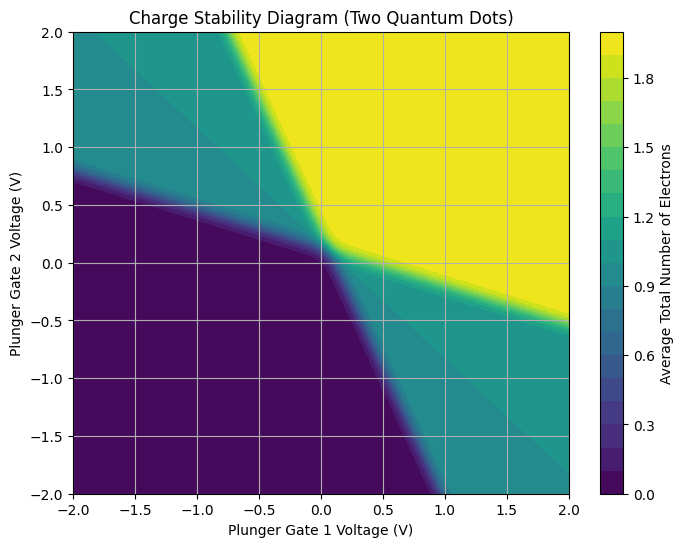

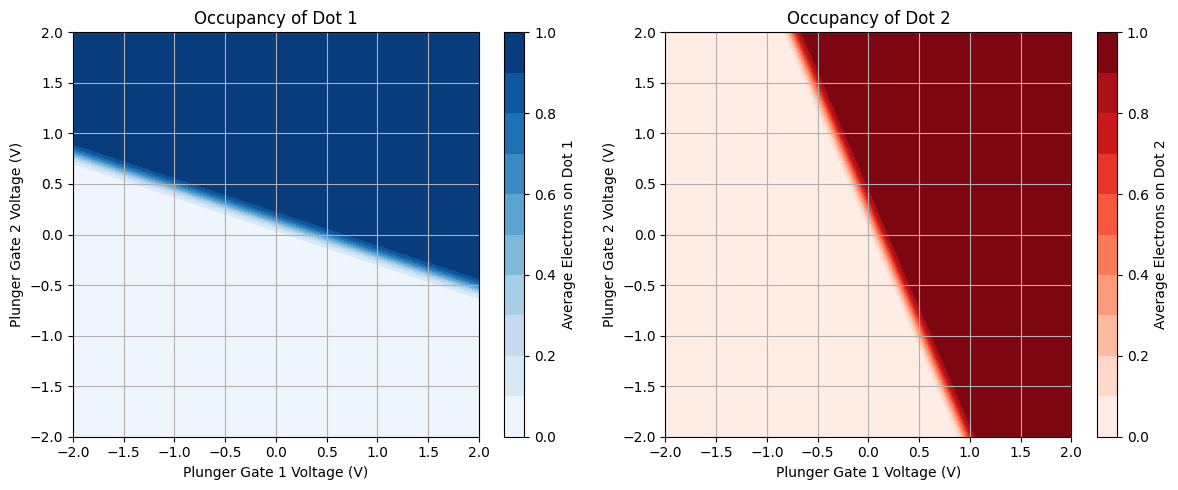

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
e = 1.602e-19  # Elementary charge (C)
kB = 1.38e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (Kelvin)

# Quantum dot parameters
C1 = 1e-18  # Capacitance of dot 1 (F)
C2 = 1e-18  # Capacitance of dot 2 (F)
U1 = e**2 / C1  # Charging energy of dot 1 (J)
U2 = e**2 / C2  # Charging energy of dot 2 (J)
energy_offset1 = 0  # Ground state energy offset (eV)
energy_offset2 = 0  # Ground state energy offset (eV)

# Lever arms (capacitive coupling factors)
alpha11 = 0.6
alpha12 = 0.2
alpha21 = 0.3
alpha22 = 0.7

# Function to compute the electrochemical potential for adding an electron to dot 'i'
def electrochemical_potential(n, Vg1, Vg2, U, alpha1, alpha2, energy_offset):
    """
    Calculates the electrochemical potential to add the (n+1)-th electron to a dot.
    """
    return energy_offset * e + (n + 0.5) * U - alpha1 * e * Vg1 - alpha2 * e * Vg2

# Fermi-Dirac distribution function
def fermi_dirac(E, mu, T):
    """ Fermi-Dirac distribution """
    if T == 0:
        return 1.0 if E <= mu else 0.0
    else:
        return 1 / (np.exp((E - mu) / (kB * T)) + 1)

# Calculate the charge stability diagram
def charge_stability_diagram_two_dots(V_gate1_range, V_gate2_range, mu=0, temp=T):
    n1_map = np.zeros((len(V_gate1_range), len(V_gate2_range)))
    n2_map = np.zeros((len(V_gate1_range), len(V_gate2_range)))

    for i, Vg1 in enumerate(V_gate1_range):
        for j, Vg2 in enumerate(V_gate2_range):
            # Average occupancy of dot 1
            E_add_1 = electrochemical_potential(0, Vg1, Vg2, U1, alpha11, alpha12, energy_offset1)
            n1_map[i, j] = fermi_dirac(E_add_1, mu, temp)

            # Average occupancy of dot 2
            E_add_2 = electrochemical_potential(0, Vg1, Vg2, U2, alpha21, alpha22, energy_offset2)
            n2_map[i, j] = fermi_dirac(E_add_2, mu, temp)

    return n1_map, n2_map

# Define the range for the gate voltages
V_gate1_range = np.linspace(-2, 2, 100)
V_gate2_range = np.linspace(-2, 2, 100)

# Generate charge stability diagram
n1_densities, n2_densities = charge_stability_diagram_two_dots(V_gate1_range, V_gate2_range)
total_electrons = n1_densities + n2_densities

# Plotting the charge stability diagram (total number of electrons)
plt.figure(figsize=(8, 6))
plt.contourf(V_gate1_range, V_gate2_range, total_electrons, levels=np.arange(0, 2.1, 0.1), cmap='viridis')
plt.colorbar(label='Average Total Number of Electrons')
plt.xlabel('Plunger Gate 1 Voltage (V)')
plt.ylabel('Plunger Gate 2 Voltage (V)')
plt.title('Charge Stability Diagram (Two Quantum Dots)')
plt.grid(True)
plt.show()

# Plotting the number of electrons on each dot separately
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(V_gate1_range, V_gate2_range, n1_densities, levels=np.arange(0, 1.1, 0.1), cmap='Blues')
plt.colorbar(label='Average Electrons on Dot 1')
plt.xlabel('Plunger Gate 1 Voltage (V)')
plt.ylabel('Plunger Gate 2 Voltage (V)')
plt.title('Occupancy of Dot 1')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.contourf(V_gate1_range, V_gate2_range, n2_densities, levels=np.arange(0, 1.1, 0.1), cmap='Reds')
plt.colorbar(label='Average Electrons on Dot 2')
plt.xlabel('Plunger Gate 1 Voltage (V)')
plt.ylabel('Plunger Gate 2 Voltage (V)')
plt.title('Occupancy of Dot 2')
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
e = 1.602e-19  # Elementary charge (C)
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
kB = 1.38e-23  # Boltzmann constant
T = 4.2  # Temperature (K) - important for Fermi-Dirac
U1 = 1e-18  # Charging energy of dot 1 (J)
U2 = 1e-18  # Charging energy of dot 2 (J)
U12 = 0.5e-18  # Interdot Coulomb energy (J), can vary from 0.1e-18 to 1e-18

energy_offset1 = 0
energy_offset2 = 0
mu_lead = 0 # Electrochemical potential of the lead

# Simulation parameters
L = 100e-9  # Length of the square domain (m)
Nx = 50  # Number of grid points in x-direction
Ny = 50  # Number of grid points in y-direction
dx = L / (Nx - 1)  # Grid spacing in x (m)
dy = L / (Ny - 1)  # Grid spacing in y (m)
gate_width = 10e-9  # Width of the gate
gate_offset = 20e-9  # Offset of the gate from the edge

# Quantum dot parameters (simplified representation)
dot_radius = 5e-9  # Radius of the dots (m)
dot1_center = (L / 4, L / 2)  # Center of dot 1
dot2_center = (3 * L / 4, L / 2)  # Center of dot 2
dot_charge_density_max = 1e-6  # Max charge density, scaling factor.

# Function to initialize the potential and charge density
def initialize_simulation(Nx, Ny, dx, dy, gate_width, gate_offset, dot1_center, dot2_center):
    """
    Initializes the simulation domain and arrays.  Charge density is now zero.
    """
    phi = np.zeros((Nx, Ny))
    rho = np.zeros((Nx, Ny))
    return phi, rho

# Function to solve Poisson's equation using FDM (Jacobi's method)
def solve_poisson_fdm(phi, rho, Nx, Ny, dx, dy, max_iter=1000, tolerance=1e-5):
    """
    Solves Poisson's equation using the Finite Difference Method with Jacobi iteration.
    """
    phi_new = np.copy(phi)
    error = tolerance + 1
    iteration = 0

    while error > tolerance and iteration < max_iter:
        iteration += 1
        error = 0.0
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                phi_new[i, j] = 0.25 * (phi[i + 1, j] + phi[i - 1, j] + phi[i, j + 1] + phi[i, j - 1] + (dx**2 / epsilon_0) * rho[i, j])
                error = max(error, abs(phi_new[i, j] - phi[i, j]))
        phi = np.copy(phi_new)
        if iteration % 100 == 0:
            print(f"Iteration: {iteration}, Error: {error}")
    #print(f"Converged after {iteration} iterations with error: {error}")
    return phi

def solve_poisson_gauss_seidel(phi, rho, Nx, Ny, dx, dy, max_iter=1000, tolerance=1e-5):
    """
    Solves Poisson's equation using the Finite Difference Method with Gauss-Seidel iteration.
    """
    phi_new = np.copy(phi)
    error = tolerance + 1
    iteration = 0

    while error > tolerance and iteration < max_iter:
        iteration += 1
        error = 0.0
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                phi_new[i, j] = 0.25 * (phi_new[i + 1, j] + phi_new[i - 1, j] + phi_new[i, j + 1] + phi_new[i, j - 1] + (dx**2 / epsilon_0) * rho[i, j])
                error = max(error, abs(phi_new[i, j] - phi[i, j]))
        phi = np.copy(phi_new) # Update phi for the next iteration's error calculation
        if iteration % 100 == 0:
            print(f"GS Iteration: {iteration}, Error: {error}")
    #print(f"Converged after {iteration} iterations with error: {error}")
    return phi_new # Return the converged potential

# Function to calculate potential at dot centers
def get_dot_potentials(phi, Nx, Ny, dx, dy, dot1_center, dot2_center):
    """
    Extracts the electrostatic potential at the center of each quantum dot.
    """
    x1_index = int(round(dot1_center[0] / dx))
    y1_index = int(round(dot1_center[1] / dy))
    x2_index = int(round(dot2_center[0] / dx))
    y2_index = int(round(dot2_center[1] / dy))
    phi1 = phi[x1_index, y1_index]
    phi2 = phi[x2_index, y2_index]
    return phi1, phi2

# Fermi-Dirac distribution function
def fermi_dirac(E, mu, T):
    """ Fermi-Dirac distribution """
    if T == 0:
        return 1.0 if E <= mu else 0.0
    else:
        return 1 / (np.exp((E - mu) / (kB * T)) + 1)

# Function to calculate the number of electrons on each dot
# def calculate_electron_number(phi1, phi2, U1, U2, energy_offset1, energy_offset2, mu_lead, T):
#     """
#     Calculates the number of electrons on each dot using the Fermi-Dirac distribution
#     and the calculated electrostatic potential.
#     """
#     #  Electrochemical potential
#     mu1 = -e * phi1 + U1 * 0 + energy_offset1 # Assume n=0 for the FD calculation
#     mu2 = -e * phi2 + U2 * 0 + energy_offset2

#     n1 = fermi_dirac(mu1, mu_lead, T)
#     n2 = fermi_dirac(mu2, mu_lead, T)
#     return n1, n2
def calculate_electron_number(phi1, phi2, U1, U2, U12, energy_offset1, energy_offset2, mu_lead, T):
    """
    Calculates the number of electrons on each dot using Fermi-Dirac statistics,
    including interdot charging energy.
    """
    # Assume integer occupation n1 and n2 initially zero
    n1_guess = 0
    n2_guess = 0

    mu1 = -e * phi1 + U1 * n1_guess + U12 * n2_guess + energy_offset1
    mu2 = -e * phi2 + U2 * n2_guess + U12 * n1_guess + energy_offset2

    n1 = fermi_dirac(mu1, mu_lead, T)
    n2 = fermi_dirac(mu2, mu_lead, T)
    return n1, n2


# Function to set the charge density based on the number of electrons.
def set_charge_density(rho, Nx, Ny, dx, dy, dot1_center, dot2_center, dot_radius, n1, n2, dot_charge_density_max):
    """
    Sets the charge density in the quantum dot regions based on the calculated
    number of electrons.  A very simplified approach.  In a real simulation,
    you would distribute the charge more carefully.
    """
    rho = np.zeros((Nx, Ny)) #reset
    dot_area = np.pi * dot_radius**2
    charge1 = n1 * e
    charge2 = n2 * e
    # Distribute the charge over the dot area, scaling by max
    rho1_val = (charge1 / dot_area) #/ dot_charge_density_max #scale it.
    rho2_val = (charge2 / dot_area) #/ dot_charge_density_max
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy
            if (x - dot1_center[0]) ** 2 + (y - dot1_center[1]) ** 2 <= dot_radius**2:
                rho[i, j] = rho1_val #* dot_charge_density_max
            elif (x - dot2_center[0]) ** 2 + (y - dot2_center[1]) ** 2 <= dot_radius**2:
                rho[i, j] = rho2_val #* dot_charge_density_max
    return rho

if __name__ == "__main__":
    # Define the range for the gate voltages
    V_gate1_range = np.linspace(-2, 2, 21)  # Increased resolution
    V_gate2_range = np.linspace(-2, 2, 21)
    n1_results = np.zeros((len(V_gate1_range), len(V_gate2_range)))
    n2_results = np.zeros((len(V_gate1_range), len(V_gate2_range)))

    # 1. Initialize the simulation
    phi, rho = initialize_simulation(Nx, Ny, dx, dy, gate_width, gate_offset, dot1_center, dot2_center)

    # Sweep the gate voltages
    for i, Vg1 in enumerate(V_gate1_range):
        for j, Vg2 in enumerate(V_gate2_range):
            # Set boundary conditions (gates)
            for k in range(Nx):
                y = k * dy
                if gate_offset <= y <= gate_offset + gate_width:
                    phi[0, k] = Vg1
                if gate_offset <= y <= gate_offset + gate_width:
                    phi[Nx - 1, k] = Vg2

            # 2. Solve Poisson's equation (and iterate to self-consistency)
            n1_old = 0
            n2_old = 0
            for self_consistent_iter in range(10): # Max self-consistent iterations
                phi = solve_poisson_gauss_seidel(phi, rho, Nx, Ny, dx, dy)
                phi1, phi2 = get_dot_potentials(phi, Nx, Ny, dx, dy, dot1_center, dot2_center)
                n1, n2 = calculate_electron_number(phi1, phi2, U1, U2, U12, energy_offset1, energy_offset2, mu_lead, T)
                rho = set_charge_density(rho, Nx, Ny, dx, dy, dot1_center, dot2_center, dot_radius, n1, n2, dot_charge_density_max)
                if np.abs(n1 - n1_old) < 1e-3 and np.abs(n2 - n2_old) < 1e-3:
                    break # Converged
                n1_old = n1
                n2_old = n2
            print(f"Vg1={Vg1:.2f}, Vg2={Vg2:.2f}, n1={n1:.2f}, n2={n2:.2f}, Self-consistent iterations: {self_consistent_iter}")
            n1_results[i, j] = n1
            n2_results[i, j] = n2

    # 3. Plot the charge stability diagram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(n1_results.T, origin='lower', extent=[V_gate1_range.min(), V_gate1_range.max(), V_gate2_range.min(), V_gate2_range.max()], cmap='viridis', aspect='auto')
    plt.colorbar(label='n1')
    plt.xlabel('V_gate1 (V)')
    plt.ylabel('V_gate2 (V)')
    plt.title('Dot 1 Occupancy')

    plt.subplot(1, 2, 2)
    plt.imshow(n2_results.T, origin='lower', extent=[V_gate1_range.min(), V_gate1_range.max(), V_gate2_range.min(), V_gate2_range.max()], cmap='viridis', aspect='auto')
    plt.colorbar(label='n2')
    plt.xlabel('V_gate1 (V)')
    plt.ylabel('V_gate2 (V)')
    plt.title('Dot 2 Occupancy')

    plt.tight_layout()
    plt.show()


GS Iteration: 100, Error: 0.0009844773820787966
GS Iteration: 200, Error: 0.00036454859730486455
GS Iteration: 300, Error: 0.0002253937899872882
GS Iteration: 400, Error: 0.00014376824180893644
GS Iteration: 500, Error: 9.371670833624446e-05
GS Iteration: 600, Error: 6.172709850513214e-05
GS Iteration: 700, Error: 4.0800656181880224e-05
GS Iteration: 800, Error: 2.7021743310207125e-05
GS Iteration: 900, Error: 1.7904654950384735e-05
GS Iteration: 1000, Error: 1.1864927494761868e-05
Vg1=-2.00, Vg2=-2.00, n1=0.00, n2=0.00, Self-consistent iterations: 0
GS Iteration: 100, Error: 9.453429208139408e-05
GS Iteration: 200, Error: 2.5731814056434432e-05
GS Iteration: 300, Error: 1.0964197343144022e-05
Vg1=-2.00, Vg2=-1.80, n1=0.00, n2=0.00, Self-consistent iterations: 0
GS Iteration: 100, Error: 0.00010116073446117535
GS Iteration: 200, Error: 3.179254159157985e-05
GS Iteration: 300, Error: 1.568079357516794e-05
Vg1=-2.00, Vg2=-1.60, n1=0.00, n2=0.00, Self-consistent iterations: 0
GS Iteration

KeyboardInterrupt: 

Vg1=-2.00, Vg2=-2.00, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.80, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-1.80, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-2.00, n1=0.00, n2=0.00
Vg1=-1.60, Vg2=-2.00, n1=0.00, n2=0.00
Vg1=-1.40, Vg2=-2.00, n1=0.00, n2=0.00
Vg1=-1.40, Vg2=-1.80, n1=0.00, n2=0.00
Vg1=-1.60, Vg2=-1.80, n1=0.00, n2=0.00
Vg1=-1.60, Vg2=-1.60, n1=0.00, n2=0.00
Vg1=-1.40, Vg2=-1.60, n1=0.00, n2=0.00
Vg1=-1.40, Vg2=-1.40, n1=0.00, n2=0.00
Vg1=-1.60, Vg2=-1.40, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-1.40, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-1.60, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.60, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.40, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.20, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-1.20, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-1.00, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.00, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-0.80, n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-0.60, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-0.60, n1=0.00, n2=0.00
Vg1=-1.80, Vg2=-0.80, n1=0.00, n2=0.00
Vg1=-1.60, Vg2=-0.80, n1=0.00, n2=0.00
Vg1=-1.60, Vg2=-0.60, n1=

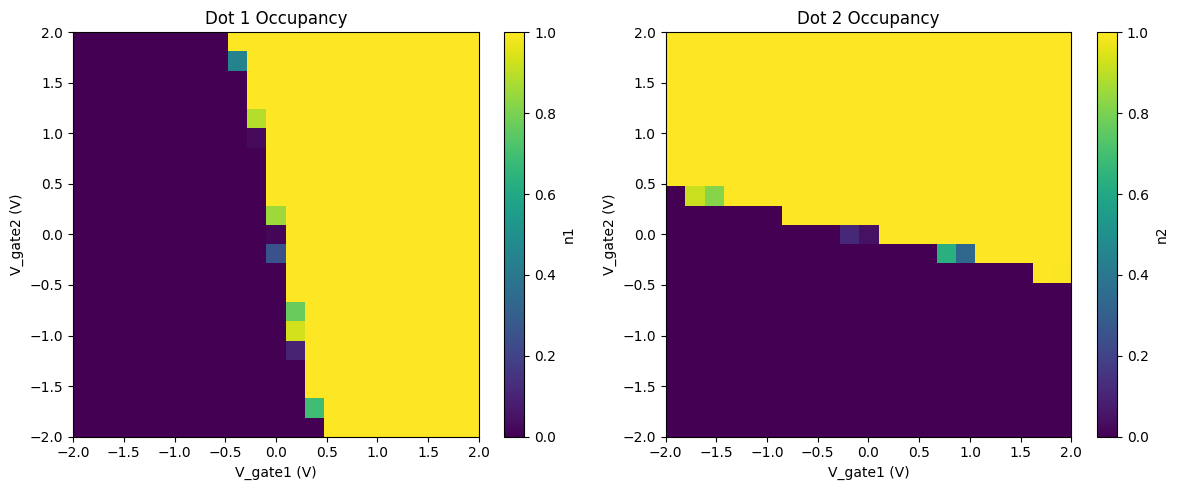

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from hilbertcurve.hilbertcurve import HilbertCurve

# Constants
e = 1.602e-19  # Elementary charge (C)
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
kB = 1.38e-23  # Boltzmann constant
T = 4.2  # Temperature (K)
U1 = 1e-18  # Charging energy of dot 1 (J)
U2 = 1e-18  # Charging energy of dot 2 (J)
U12 = 0.5e-18  # Interdot Coulomb energy (J), can vary from 0.1e-18 to 1e-18

energy_offset1 = 0
energy_offset2 = 0
mu_lead = 0  # Electrochemical potential of the lead

# Simulation parameters
L = 100e-9  # Length of the square domain (m)
Nx = 50  # Number of grid points in x-direction
Ny = 50  # Number of grid points in y-direction
dx = L / (Nx - 1)  # Grid spacing in x (m)
dy = L / (Ny - 1)  # Grid spacing in y (m)
gate_width = 10e-9  # Width of the gate
gate_offset = 20e-9  # Offset of the gate from the edge

# Quantum dot parameters
dot_radius = 5e-9  # Radius of the dots (m)
dot1_center = (L / 4, L / 2)  # Center of dot 1
dot2_center = (3 * L / 4, L / 2)  # Center of dot 2
dot_charge_density_max = 1e-6  # Max charge density, scaling factor.

# Function to initialize the potential and charge density
def initialize_simulation(Nx, Ny):
    phi = np.zeros((Nx, Ny))
    rho = np.zeros((Nx, Ny))
    return phi, rho

# Gauss-Seidel solver for Poisson's equation
def solve_poisson_gauss_seidel(phi, rho, Nx, Ny, dx, dy, max_iter=1000, tolerance=1e-5):
    error = tolerance + 1
    iteration = 0
    while error > tolerance and iteration < max_iter:
        error = 0.0
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                phi_new = 0.25 * (phi[i+1, j] + phi[i-1, j] + phi[i, j+1] + phi[i, j-1] + (dx**2 / epsilon_0) * rho[i, j])
                error = max(error, abs(phi_new - phi[i, j]))
                phi[i, j] = phi_new
        iteration += 1
    return phi

# Function to extract potentials at dot centers
def get_dot_potentials(phi, dx, dy, dot1_center, dot2_center):
    x1_idx = int(dot1_center[0] / dx)
    y1_idx = int(dot1_center[1] / dy)
    x2_idx = int(dot2_center[0] / dx)
    y2_idx = int(dot2_center[1] / dy)
    return phi[x1_idx, y1_idx], phi[x2_idx, y2_idx]

# Fermi-Dirac distribution
def fermi_dirac(E, mu, T):
    if T == 0:
        return 1.0 if E <= mu else 0.0
    else:
        return 1 / (np.exp((E - mu) / (kB * T)) + 1)

# Calculate electron numbers on dots
# def calculate_electron_number(phi1, phi2, U1, U2, energy_offset1, energy_offset2, mu_lead, T):
#     mu1 = -e * phi1 + energy_offset1
#     mu2 = -e * phi2 + energy_offset2
#     n1 = fermi_dirac(mu1, mu_lead, T)
#     n2 = fermi_dirac(mu2, mu_lead, T)
#     return n1, n2

def calculate_electron_number(phi1, phi2, U1, U2, U12, energy_offset1, energy_offset2, mu_lead, T):
    """
    Calculates the number of electrons on each dot using Fermi-Dirac statistics,
    including interdot charging energy.
    """
    # Assume integer occupation n1 and n2 initially zero
    n1_guess = 0
    n2_guess = 0

    mu1 = -e * phi1 + U1 * n1_guess + U12 * n2_guess + energy_offset1
    mu2 = -e * phi2 + U2 * n2_guess + U12 * n1_guess + energy_offset2

    n1 = fermi_dirac(mu1, mu_lead, T)
    n2 = fermi_dirac(mu2, mu_lead, T)
    return n1, n2

# Set charge density based on electron numbers
def set_charge_density(Nx, Ny, dx, dy, dot1_center, dot2_center, dot_radius, n1, n2):
    rho = np.zeros((Nx, Ny))
    dot_area = np.pi * dot_radius**2
    charge1 = n1 * e
    charge2 = n2 * e
    rho1_val = charge1 / dot_area
    rho2_val = charge2 / dot_area
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy
            if (x - dot1_center[0])**2 + (y - dot1_center[1])**2 <= dot_radius**2:
                rho[i, j] = rho1_val
            elif (x - dot2_center[0])**2 + (y - dot2_center[1])**2 <= dot_radius**2:
                rho[i, j] = rho2_val
    return rho

# Main simulation
if __name__ == "__main__":
    V_gate1_range = np.linspace(-2, 2, 21)
    V_gate2_range = np.linspace(-2, 2, 21)
    n1_results = np.zeros((len(V_gate1_range), len(V_gate2_range)))
    n2_results = np.zeros((len(V_gate1_range), len(V_gate2_range)))

    # Determine Hilbert curve order
    grid_size = len(V_gate1_range)
    hilbert_order = int(np.ceil(np.log2(grid_size)))
    hilbert_dim = 2
    hilbert_curve = HilbertCurve(p=hilbert_order, n=hilbert_dim)

    # Generate Hilbert traversal order
    index_map = []
    for i in range(grid_size):
        for j in range(grid_size):
            h = hilbert_curve.distance_from_point([i, j])
            index_map.append((h, i, j))
    index_map.sort()

    phi_prev = None  # For warm start

    for _, i, j in index_map:
        Vg1 = V_gate1_range[i]
        Vg2 = V_gate2_range[j]

        # Warm start
        if phi_prev is not None:
            phi = np.copy(phi_prev)
        else:
            phi, _ = initialize_simulation(Nx, Ny)

        # Set boundary conditions
        for k in range(Nx):
            y = k * dy
            if gate_offset <= y <= gate_offset + gate_width:
                phi[0, k] = Vg1
                phi[Nx - 1, k] = Vg2

        # Self-consistent loop
        n1_old = 0
        n2_old = 0
        for _ in range(10):
            rho = set_charge_density(Nx, Ny, dx, dy, dot1_center, dot2_center, dot_radius, n1_old, n2_old)
            phi = solve_poisson_gauss_seidel(phi, rho, Nx, Ny, dx, dy)
            phi1, phi2 = get_dot_potentials(phi, dx, dy, dot1_center, dot2_center)
            n1, n2 = calculate_electron_number(phi1, phi2, U1, U2, energy_offset1, energy_offset2, mu_lead, T)
            if abs(n1 - n1_old) < 1e-3 and abs(n2 - n2_old) < 1e-3:
                break
            n1_old, n2_old = n1, n2

        print(f"Vg1={Vg1:.2f}, Vg2={Vg2:.2f}, n1={n1:.2f}, n2={n2:.2f}")
        n1_results[i, j] = n1
        n2_results[i, j] = n2
        phi_prev = np.copy(phi)

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(n1_results.T, origin='lower', extent=[V_gate1_range.min(), V_gate1_range.max(),
               V_gate2_range.min(), V_gate2_range.max()], cmap='viridis', aspect='auto')
    plt.colorbar(label='n1')
    plt.xlabel('V_gate1 (V)')
    plt.ylabel('V_gate2 (V)')
    plt.title('Dot 1 Occupancy')

    plt.subplot(1, 2, 2)
    plt.imshow(n2_results.T, origin='lower', extent=[V_gate1_range.min(), V_gate1_range.max(),
               V_gate2_range.min(), V_gate2_range.max()], cmap='viridis', aspect='auto')
    plt.colorbar(label='n2')
    plt.xlabel('V_gate1 (V)')
    plt.ylabel('V_gate2 (V)')
    plt.title('Dot 2 Occupancy')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1214761/1148264942.py:59: RuntimeWarning: overflow encountered in exp
  return 1.0 if T == 0 and E <= mu else 1 / (np.exp((E - mu) / (kB * T)) + 1)


Vg1=-2.00, Vg2=-2.00 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.87 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.87 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-2.00 → n1=0.00, n2=0.00
Vg1=-1.74, Vg2=-2.00 → n1=0.00, n2=0.00
Vg1=-1.61, Vg2=-2.00 → n1=0.00, n2=0.00
Vg1=-1.61, Vg2=-1.87 → n1=0.00, n2=0.00
Vg1=-1.74, Vg2=-1.87 → n1=0.00, n2=0.00
Vg1=-1.74, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-1.61, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-1.61, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.74, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.35 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.35 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.23 → n1=0.00, n2=0.00
Vg1=-2.00, Vg2=-1.10 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.10 → n1=0.00, n2=0.00
Vg1=-1.87, Vg2=-1.23 → n1=0.00, n2=0.00
Vg1=-1.74, Vg2=-1.23 → n1=0.00, n2=0.00


/tmp/ipykernel_1214761/1148264942.py:163: RuntimeWarning: overflow encountered in exp
  return 1.0 if T == 0 and E <= mu else 1 / (np.exp((E - mu) / (kB * T)) + 1)


Vg1=-1.61, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.48, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.35, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.35, Vg2=-1.35 → n1=0.00, n2=0.00
Vg1=-1.48, Vg2=-1.35 → n1=0.00, n2=0.00
Vg1=-1.48, Vg2=-1.23 → n1=0.00, n2=0.00
Vg1=-1.48, Vg2=-1.10 → n1=0.00, n2=0.00
Vg1=-1.35, Vg2=-1.10 → n1=0.00, n2=0.00
Vg1=-1.35, Vg2=-1.23 → n1=0.00, n2=0.00
Vg1=-1.23, Vg2=-1.23 → n1=0.00, n2=0.00
Vg1=-1.23, Vg2=-1.10 → n1=0.00, n2=0.00
Vg1=-1.10, Vg2=-1.10 → n1=0.00, n2=0.00
Vg1=-1.10, Vg2=-1.23 → n1=0.00, n2=0.00
Vg1=-1.10, Vg2=-1.35 → n1=0.00, n2=0.00
Vg1=-1.23, Vg2=-1.35 → n1=0.00, n2=0.00
Vg1=-1.23, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.10, Vg2=-1.48 → n1=0.00, n2=0.00
Vg1=-1.10, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.10, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-1.23, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-1.23, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.35, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.48, Vg2=-1.61 → n1=0.00, n2=0.00
Vg1=-1.48, Vg2=-1.74 → n1=0.00, n2=0.00
Vg1=-1.35, Vg2=-1.74 → n1=0.00, n2=0.00


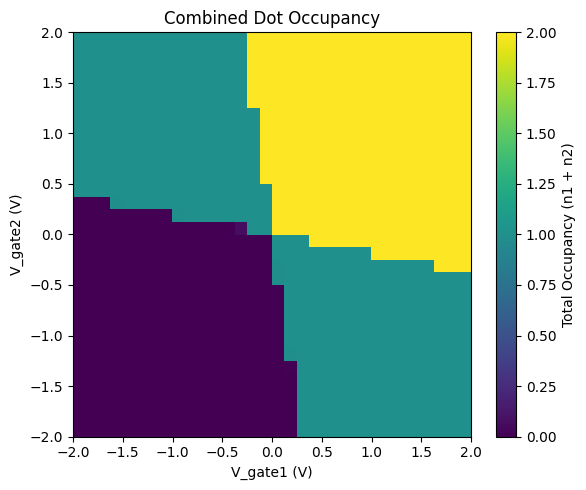

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from hilbertcurve.hilbertcurve import HilbertCurve

# Constants
e = 1.602e-19
epsilon_0 = 8.854e-12
kB = 1.38e-23
T = 4.2
energy_offset1 = 0
energy_offset2 = 0
mu_lead = 0

# Simulation grid (must be power of 2)
Nx = 32
Ny = 32
L = 100e-9
dx = L / (Nx - 1)
dy = L / (Ny - 1)

# Dot parameters
dot_radius = 5e-9
dot1_center = (L / 4, L / 2)
dot2_center = (3 * L / 4, L / 2)

# Gate voltage grid (also power of 2)
Nvg = 32
V_range = np.linspace(-2, 2, Nvg)

# Hilbert curve in gate voltage space
p = int(np.log2(Nvg))
vg_curve = HilbertCurve(p, 2)
num_points = 2 ** (p * 2)
grid_coords = [vg_curve.point_from_distance(d) for d in range(num_points)]

grid_coords = [(i, j, V_range[i], V_range[j]) for i, j in grid_coords]

# Storage
n1_results = np.zeros((Nvg, Nvg))
n2_results = np.zeros((Nvg, Nvg))

# Initialize phi and rho for warm-starting
phi = np.zeros((Nx, Ny))
rho = np.zeros((Nx, Ny))

# Simulation helpers
def solve_poisson(phi, rho, max_iter=500, tol=1e-5):
    for _ in range(max_iter):
        phi_old = phi.copy()
        phi[1:-1,1:-1] = 0.25 * (
            phi[2:,1:-1] + phi[:-2,1:-1] + phi[1:-1,2:] + phi[1:-1,:-2]
            + (dx**2 / epsilon_0) * rho[1:-1,1:-1]
        )
        if np.max(np.abs(phi - phi_old)) < tol:
            break
    return phi

def fermi_dirac(E, mu):
    return 1.0 if T == 0 and E <= mu else 1 / (np.exp((E - mu) / (kB * T)) + 1)

def get_dot_potentials(phi):
    i1, j1 = int(dot1_center[0] / dx), int(dot1_center[1] / dy)
    i2, j2 = int(dot2_center[0] / dx), int(dot2_center[1] / dy)
    return phi[i1, j1], phi[i2, j2]

def compute_occupancy(phi1, phi2):
    mu1 = -e * phi1 + energy_offset1
    mu2 = -e * phi2 + energy_offset2
    return fermi_dirac(mu1, mu_lead), fermi_dirac(mu2, mu_lead)

def update_charge_density(n1, n2):
    rho = np.zeros((Nx, Ny))
    dot_area = np.pi * dot_radius**2
    charge1 = n1 * e / dot_area
    charge2 = n2 * e / dot_area
    for i in range(Nx):
        for j in range(Ny):
            x, y = i * dx, j * dy
            if (x - dot1_center[0])**2 + (y - dot1_center[1])**2 <= dot_radius**2:
                rho[i,j] = charge1
            elif (x - dot2_center[0])**2 + (y - dot2_center[1])**2 <= dot_radius**2:
                rho[i,j] = charge2
    return rho

# Main loop with warm starting
for i, j, Vg1, Vg2 in grid_coords:
    # Boundary conditions
    phi[0,:] = Vg1
    phi[-1,:] = Vg2

    # Self-consistent loop
    for _ in range(10):
        phi = solve_poisson(phi, rho)
        phi1, phi2 = get_dot_potentials(phi)
        n1, n2 = compute_occupancy(phi1, phi2)
        new_rho = update_charge_density(n1, n2)
        if np.allclose(rho, new_rho, atol=1e-3):
            break
        rho = new_rho

    n1_results[i, j] = n1
    n2_results[i, j] = n2
    print(f"Vg1={Vg1:.2f}, Vg2={Vg2:.2f} → n1={n1:.2f}, n2={n2:.2f}")

import numpy as np
import matplotlib.pyplot as plt
from hilbertcurve.hilbertcurve import HilbertCurve

# Constants
e = 1.602e-19
epsilon_0 = 8.854e-12
kB = 1.38e-23
T = 4.2
energy_offset1 = 0
energy_offset2 = 0
mu_lead = 0

# Simulation grid (must be power of 2)
Nx = 32
Ny = 32
L = 100e-9
dx = L / (Nx - 1)
dy = L / (Ny - 1)

# Dot parameters
dot_radius = 5e-9
dot1_center = (L / 4, L / 2)
dot2_center = (3 * L / 4, L / 2)

# Gate voltage grid (also power of 2)
Nvg = 32
V_range = np.linspace(-2, 2, Nvg)

# Hilbert curve in gate voltage space
p = int(np.log2(Nvg))
vg_curve = HilbertCurve(p, 2)
num_points = 2 ** (p * 2)
grid_coords = [vg_curve.point_from_distance(d) for d in range(num_points)]

grid_coords = [(i, j, V_range[i], V_range[j]) for i, j in grid_coords]

# Storage
n1_results = np.zeros((Nvg, Nvg))
n2_results = np.zeros((Nvg, Nvg))

# Initialize phi and rho for warm-starting
phi = np.zeros((Nx, Ny))
rho = np.zeros((Nx, Ny))

# Simulation helpers
def solve_poisson(phi, rho, max_iter=500, tol=1e-5):
    for _ in range(max_iter):
        phi_old = phi.copy()
        phi[1:-1,1:-1] = 0.25 * (
            phi[2:,1:-1] + phi[:-2,1:-1] + phi[1:-1,2:] + phi[1:-1,:-2]
            + (dx**2 / epsilon_0) * rho[1:-1,1:-1]
        )
        if np.max(np.abs(phi - phi_old)) < tol:
            break
    return phi

def fermi_dirac(E, mu):
    return 1.0 if T == 0 and E <= mu else 1 / (np.exp((E - mu) / (kB * T)) + 1)

def get_dot_potentials(phi):
    i1, j1 = int(dot1_center[0] / dx), int(dot1_center[1] / dy)
    i2, j2 = int(dot2_center[0] / dx), int(dot2_center[1] / dy)
    return phi[i1, j1], phi[i2, j2]

def compute_occupancy(phi1, phi2):
    mu1 = -e * phi1 + energy_offset1
    mu2 = -e * phi2 + energy_offset2
    return fermi_dirac(mu1, mu_lead), fermi_dirac(mu2, mu_lead)

def update_charge_density(n1, n2):
    rho = np.zeros((Nx, Ny))
    dot_area = np.pi * dot_radius**2
    charge1 = n1 * e / dot_area
    charge2 = n2 * e / dot_area
    for i in range(Nx):
        for j in range(Ny):
            x, y = i * dx, j * dy
            if (x - dot1_center[0])**2 + (y - dot1_center[1])**2 <= dot_radius**2:
                rho[i,j] = charge1
            elif (x - dot2_center[0])**2 + (y - dot2_center[1])**2 <= dot_radius**2:
                rho[i,j] = charge2
    return rho

# Main loop with warm starting
for i, j, Vg1, Vg2 in grid_coords:
    # Boundary conditions
    phi[0,:] = Vg1
    phi[-1,:] = Vg2

    # Self-consistent loop
    for _ in range(10):
        phi = solve_poisson(phi, rho)
        phi1, phi2 = get_dot_potentials(phi)
        n1, n2 = compute_occupancy(phi1, phi2)
        new_rho = update_charge_density(n1, n2)
        if np.allclose(rho, new_rho, atol=1e-3):
            break
        rho = new_rho

    n1_results[i, j] = n1
    n2_results[i, j] = n2
    print(f"Vg1={Vg1:.2f}, Vg2={Vg2:.2f} → n1={n1:.2f}, n2={n2:.2f}")


# Combine dot occupancies
n_total = n1_results + n2_results

# Plot the combined charge stability diagram
plt.figure(figsize=(6, 5))
plt.imshow(
    n_total.T,  # Transpose for correct orientation
    origin='lower',
    extent=[V_gate1_range.min(), V_gate1_range.max(), V_gate2_range.min(), V_gate2_range.max()],
    cmap='viridis',
    aspect='auto'
)
plt.colorbar(label='Total Occupancy (n1 + n2)')
plt.xlabel('V_gate1 (V)')
plt.ylabel('V_gate2 (V)')
plt.title('Combined Dot Occupancy')
plt.tight_layout()
plt.show()

